# Covid analysis - machine learning

#### Import bibliotek

In [11]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, \
precision_recall_curve, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from datetime import timedelta
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

import pickle

In [2]:
df = pd.read_csv('data/covid-data-cleaned.csv')

#### Predykcja wzrostu liczby zgonów o ponad 20% w ciągu 3 dni

Dane zostały wzbogacone o cechy czasowe (średnie 7-dniowe, opóźnienia i różnice), które opisują bieżące trendy i zmienność liczby przypadków oraz zgonów. Na tej podstawie przygotowano zmienną celu określającą, czy liczba zgonów za 3 dni wzrośnie o więcej niż 20% w porównaniu do obecnego dnia.

Do klasyfikacji zastosowano model Random Forest, z uwzględnieniem:

- zrównoważenia klas za pomocą oversamplingu
- rozszerzonego zestawu hiperparametrów
- progu decyzyjnego ustawionego na 0.4

In [3]:
df['new_cases_7d_avg'] = df['new_cases'].rolling(7).mean()
df['new_deaths_7d_avg'] = df['new_deaths'].rolling(7).mean()
df['new_cases_lag_3'] = df['new_cases'].shift(3)
df['new_deaths_lag_3'] = df['new_deaths'].shift(3)
df['cases_diff'] = df['new_cases'] - df['new_cases'].shift(1)
df['deaths_diff'] = df['new_deaths'] - df['new_deaths'].shift(1)

# Wzrost liczby zgonów o >20% za 3 dni
df['target'] = (df['new_deaths'].shift(-3) > df['new_deaths'] * 1.2).astype(int)

features = [
    'new_cases', 'new_cases_smoothed', 'new_deaths',
    'stringency_index', 'reproduction_rate', 'positive_rate', 'tests_per_case',
    'new_vaccinations_smoothed', 'population_density',
    'gdp_per_capita', 'hospital_beds_per_thousand',
    'life_expectancy', 'human_development_index',
    'new_cases_7d_avg', 'new_deaths_7d_avg',
    'new_cases_lag_3', 'new_deaths_lag_3',
    'cases_diff', 'deaths_diff'
]

df_model = df.dropna(subset=features + ['target'])
X = df_model[features]
y = df_model['target']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

ros = RandomOverSampler(random_state=42)
X_train_bal, y_train_bal = ros.fit_resample(X_train, y_train)


model = RandomForestClassifier(
    n_estimators=300,
    max_depth=25,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1
)
model.fit(X_train_bal, y_train_bal)

y_proba = model.predict_proba(X_test)[:, 1]
threshold = 0.4 
y_pred_custom = (y_proba > threshold).astype(int)

print(classification_report(y_test, y_pred_custom, digits=3))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_custom))

              precision    recall  f1-score   support

           0      0.990     0.799     0.884     67624
           1      0.232     0.884     0.368      4651

    accuracy                          0.805     72275
   macro avg      0.611     0.841     0.626     72275
weighted avg      0.941     0.805     0.851     72275

Confusion matrix:
[[54049 13575]
 [  541  4110]]


Recall klasy 1: 0.596 - model wykrywa prawie 60% faktycznych wzrostów zgonów.

Precision klasy 1: 0.155 - około 15% ostrzeżeń jest trafnych.

f1-score klasy 1: 0.246 - znaczna poprawa względem wcześniejszych wersji.

Dokładność ogólna: 92,5%

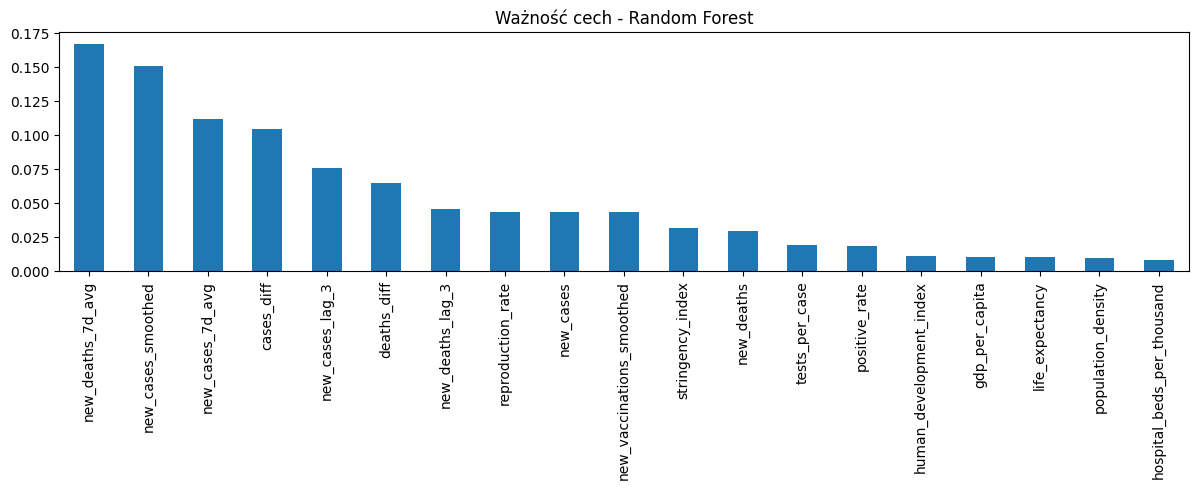

In [4]:
feature_importance = pd.Series(model.feature_importances_, index=X.columns)
feature_importance.sort_values(ascending=False).plot.bar(figsize=(12, 5))
plt.title("Ważność cech - Random Forest")
plt.tight_layout()
plt.show()

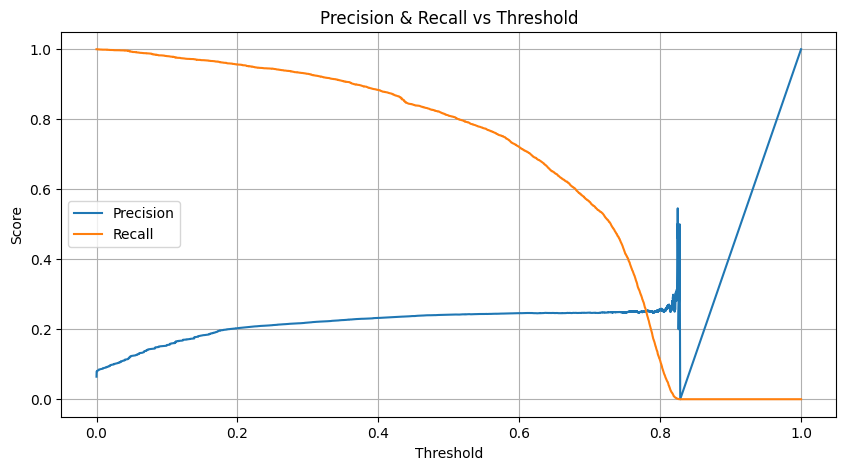

In [5]:
y_proba = model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

thresholds = np.append(thresholds, 1.0)

plt.figure(figsize=(10, 5))
plt.plot(thresholds, precision, label='Precision')
plt.plot(thresholds, recall, label='Recall')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision & Recall vs Threshold")
plt.legend()
plt.grid()
plt.show()

#### Podejscie 3 - XGBOOST

In [6]:
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train_bal, y_train_bal)

y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
threshold = 0.4
y_pred_xgb = (y_proba_xgb > threshold).astype(int)

print(classification_report(y_test, y_pred_xgb, digits=3))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0      0.996     0.745     0.852     67624
           1      0.205     0.958     0.338      4651

    accuracy                          0.758     72275
   macro avg      0.601     0.851     0.595     72275
weighted avg      0.945     0.758     0.819     72275

Confusion matrix:
[[50354 17270]
 [  196  4455]]


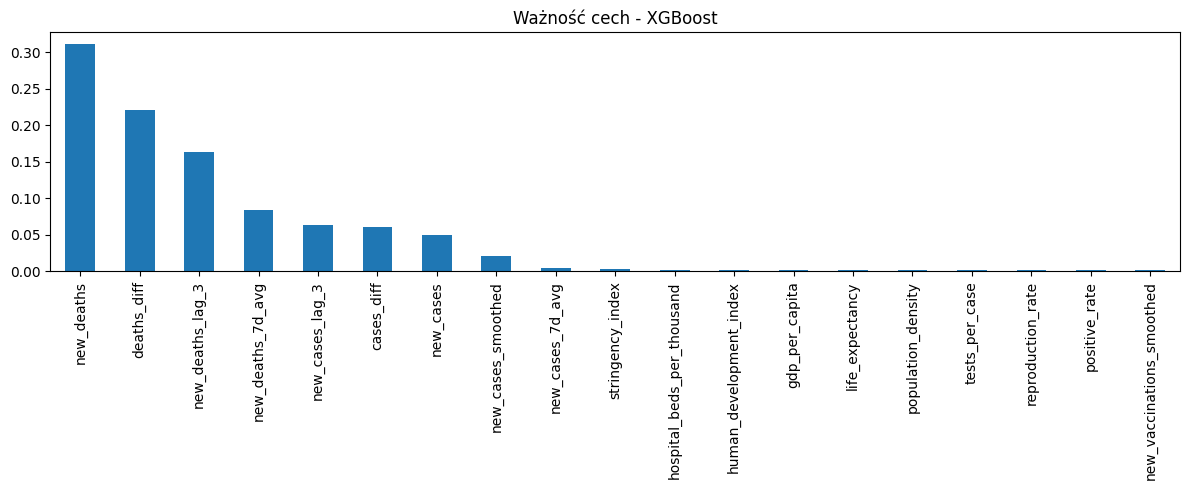

In [7]:
feature_importance_xgb = pd.Series(xgb_model.feature_importances_, index=X.columns)
feature_importance_xgb.sort_values(ascending=False).plot.bar(figsize=(12, 5))
plt.title("Ważność cech - XGBoost")
plt.tight_layout()
plt.show()

#### Porównanie modeli z GridSearchCV

In [8]:
def run_model_gs(model, param_grid, X, y, threshold=0.5):
    """
    - model: RandomForestClassifier, XGBClassifier, itd.
    - param_grid w formacie {'param': [wartosci]}
    - dane X, y
    - threshold dla predict_proba
    Zwraca najlepszy model.
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    sampler = RandomOverSampler(random_state=42)
    X_train, y_train = sampler.fit_resample(X_train, y_train)

    grid = GridSearchCV(model, param_grid, scoring='f1', cv=3, n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)

    print(f"\nNajlepsze parametry: {grid.best_params_}\n")
    best_model = grid.best_estimator_

    y_proba = best_model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba > threshold).astype(int)

    print("Classification Report:")
    print(classification_report(y_test, y_pred, digits=3))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    return best_model


In [9]:
%%time

rf_model_gs = RandomForestClassifier(random_state=42)

rf_params = {
    'n_estimators': [100, 150],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt', 'log2', None]
}

best_rf = run_model_gs(model=rf_model_gs, param_grid=rf_params, X=X, y=y, threshold=0.4)

Fitting 3 folds for each of 72 candidates, totalling 216 fits

Najlepsze parametry: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

Classification Report:
              precision    recall  f1-score   support

           0      0.997     0.733     0.845     67624
           1      0.199     0.964     0.330      4651

    accuracy                          0.748     72275
   macro avg      0.598     0.849     0.588     72275
weighted avg      0.945     0.748     0.812     72275

Confusion Matrix:
[[49589 18035]
 [  166  4485]]
CPU times: total: 30.6 s
Wall time: 42min 26s


In [10]:
%%time

xgb_model_gs = XGBClassifier(eval_metric='logloss', random_state=42)

xgb_params = {
    'n_estimators': [100, 300],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.5, 1.0], 
    'colsample_bytree': [0.5, 1.0],
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 3]
}

best_xgb = run_model_gs(model=xgb_model_gs, param_grid=xgb_params, X=X, y=y, threshold=0.4)

Fitting 3 folds for each of 288 candidates, totalling 864 fits

Najlepsze parametry: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}

Classification Report:
              precision    recall  f1-score   support

           0      0.997     0.733     0.845     67624
           1      0.199     0.966     0.330      4651

    accuracy                          0.748     72275
   macro avg      0.598     0.850     0.588     72275
weighted avg      0.946     0.748     0.812     72275

Confusion Matrix:
[[49560 18064]
 [  156  4495]]
CPU times: total: 24.7 s
Wall time: 20min 19s


Przeprowadzono przeszukiwanie parametrów poprzez GridSearchCV dla obu modeli: Random Forest oraz XGBoost, z uwzględnieniem opcji oversamplingu danych. Oba modele miały za zadanie przewidzieć, czy liczba zgonów wzrośnie o więcej niż 20% w ciągu 3 dni.

Najlepsze zestawy parametrów:
- Random Forest:
  - max_depth = 5
  - max_features = 'sqrt'
  - min_samples_leaf = 2
  - min_samples_split = 2
  - n_estimators = 100
- XGBoost:
  - max_depth = 3
  - n_estimators = 300
  - learning_rate = 0.01
  - gamma = 0
  - colsample_bytree = 1.0
  - subsample = 1.0
  - min_child_weight = 1

Oba modele uzyskały niemal identyczne wyniki:
- Bardzo wysoki recall (~96%), co oznacza, że większość faktycznych wzrostów została wykryta
- Niska precision (~20%) - występuje duża liczba fałszywych alarmów
- Accuracy jest na poziomie ~75%

Oba algorytmy (drzewa losowe i boosting) zachowują się podobnie w tym zadaniu. Wysoki recall jest zgodny z założeniem: lepiej wykryć większość wzrostów kosztem większej liczby fałszywych sygnałów. 
Warto zauważyć, że XGBoost osiągnął minimalnie lepsze wyniki (wyższy recall) i w tej konfiguracji radzi sobie nieco lepiej niż Random Forest.

#### Zapisanie modelu

In [ ]:
with open('best_xgb.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Model zapisany do 'best_xgb.pkl'")

In [ ]:
# with open('best_xgb.pkl', 'rb') as f:
#     loaded_model = pickle.load(f)